In [4]:
import gym
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import collections
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create CartPole environment
env = gym.make("CartPole-v1")

Using device: cpu


In [6]:
# Define DQN model
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.fc(x)

In [7]:
# Define Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (np.array(states, dtype=np.float32),
                np.array(actions, dtype=np.int64),
                np.array(rewards, dtype=np.float32),
                np.array(next_states, dtype=np.float32),
                np.array(dones, dtype=np.bool_))

    def __len__(self):
        return len(self.buffer)

In [8]:
# Train function
def train(env, num_episodes=1500):
    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.n
    model = DQN(input_dim, output_dim).to(device)
    target_model = DQN(input_dim, output_dim).to(device)
    target_model.load_state_dict(model.state_dict())
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    buffer = ReplayBuffer(100000)
    gamma = 0.99
    epsilon = 1.0
    epsilon_min = 0.01
    epsilon_decay = 0.995
    batch_size = 64
    update_target_every = 10
    rewards_list = []

    for episode in range(num_episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False

        while not done:
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                    action = torch.argmax(model(state_tensor)).item()

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            buffer.push(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            if len(buffer) > batch_size:
                states, actions, rewards, next_states, dones = buffer.sample(batch_size)
                states = torch.FloatTensor(states).to(device)
                actions = torch.LongTensor(actions).unsqueeze(1).to(device)
                rewards = torch.FloatTensor(rewards).to(device)
                next_states = torch.FloatTensor(next_states).to(device)
                dones = torch.BoolTensor(dones).to(device)

                q_values = model(states).gather(1, actions).squeeze()
                next_q_values = target_model(next_states).max(1)[0]
                target_q_values = rewards + gamma * next_q_values * (~dones)
                #loss = nn.MSELoss()(q_values, target_q_values)
                loss = nn.SmoothL1Loss()(q_values, target_q_values)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        if epsilon > epsilon_min:
            epsilon *= epsilon_decay
        if episode < 500:
            epsilon *= epsilon_decay
        elif episode < 1000:
            epsilon *= 0.999  # Slower decay
        else:
            epsilon = max(0.05, epsilon)  # Keep a minimum exploration


        rewards_list.append(total_reward)

        if episode % update_target_every == 0:
            target_model.load_state_dict(model.state_dict())

        if episode % 50 == 0:
            print(f"Episode {episode}, Reward: {total_reward}, Epsilon: {epsilon:.3f}")

    return model, rewards_list

/Users/robbieardison/anaconda3/envs/tf-pro/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 0, Reward: 19.0, Epsilon: 0.990
Episode 50, Reward: 12.0, Epsilon: 0.600
Episode 100, Reward: 13.0, Epsilon: 0.363
Episode 150, Reward: 10.0, Epsilon: 0.220
Episode 200, Reward: 10.0, Epsilon: 0.133
Episode 250, Reward: 11.0, Epsilon: 0.081
Episode 300, Reward: 34.0, Epsilon: 0.049
Episode 350, Reward: 69.0, Epsilon: 0.030
Episode 400, Reward: 55.0, Epsilon: 0.018
Episode 450, Reward: 65.0, Epsilon: 0.011
Episode 500, Reward: 117.0, Epsilon: 0.008
Episode 550, Reward: 100.0, Epsilon: 0.008
Episode 600, Reward: 100.0, Epsilon: 0.007
Episode 650, Reward: 105.0, Epsilon: 0.007
Episode 700, Reward: 128.0, Epsilon: 0.007
Episode 750, Reward: 85.0, Epsilon: 0.006
Episode 800, Reward: 105.0, Epsilon: 0.006
Episode 850, Reward: 112.0, Epsilon: 0.006
Episode 900, Reward: 126.0, Epsilon: 0.005
Episode 950, Reward: 111.0, Epsilon: 0.005
Episode 1000, Reward: 178.0, Epsilon: 0.050
Episode 1050, Reward: 148.0, Epsilon: 0.050
Episode 1100, Reward: 145.0, Epsilon: 0.050
Episode 1150, Reward: 

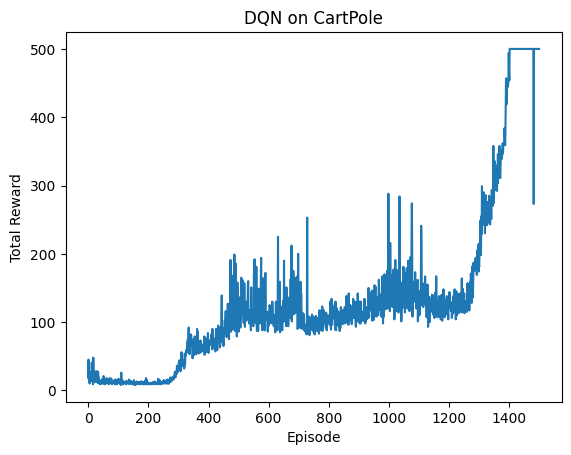

Model saved as dqn_cartpole.pth


In [9]:
# Train the agent
model, rewards = train(env)

# Plot results
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DQN on CartPole")
plt.show()

# Save the model
torch.save(model.state_dict(), "dqn_cartpole.pth")
print("Model saved as dqn_cartpole.pth")

In [14]:
import gym

env = gym.make("CartPole-v1", render_mode="human")

state = env.reset()
done = False

while not done:
    env.render()
    
    action = env.action_space.sample()  # Replace with your model's action if needed
    
    step_result = env.step(action)

    if len(step_result) == 5:
        next_state, reward, terminated, truncated, info = step_result
        done = terminated or truncated
    else:
        next_state, reward, done, info = step_result  # Older Gym versions

    state = next_state

env.close()


In [1]:
env = gym.make("LunarLander-v2")
state = env.reset()
done = False

while not done:
    env.render()
    state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
    action = model(state_tensor).argmax().item()
    state, reward, done, _ = env.step(action)

env.close()

NameError: name 'gym' is not defined